In [147]:
from typing_extensions import Literal
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage
from typing_extensions import TypedDict
import os
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from IPython.display import Markdown

In [148]:
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq


llm=ChatGroq(model="qwen-2.5-32b")
#llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 30, 'total_tokens': 40, 'completion_time': 0.05, 'prompt_time': 0.003756949, 'queue_time': 0.23460452999999998, 'total_time': 0.053756949}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_35f92f8282', 'finish_reason': 'stop', 'logprobs': None}, id='run-36ae7e11-7217-4410-b0aa-298f77d87eb6-0', usage_metadata={'input_tokens': 30, 'output_tokens': 10, 'total_tokens': 40})

In [149]:
# Graph state
class State(TypedDict):
    role: str
    job_description : str
    improved_job_description: str
    final_job_description: str
    final_interview_questions :str
    

In [150]:
# Nodes
def generate_job_description(state: State):
    """First LLM call to generate initial job description"""

    msg = llm.invoke(f"Write a job description on the {state['role']}")
    return {"job_description": msg.content}

def check_skills(state: State):
    """Gate function to check if the role has relavent skills"""

    # Simple check - does the job description  contains "Google" or "GCP"
    if "Google" in state["role"] or "GCP" in state["role"]:
        return "Pass"
    return "Fail"

def improve_job_description(state: State):
    """Second LLM call to improve the job description"""

    msg = llm.invoke(f"Make this by job description relavent adding Google, GCP and other Google tools: {state['role']}")
    return {"improved_job_description": msg.content}

def polish_job_description(state: State):
    """Third LLM call for final grammatical check"""

    msg = llm.invoke(f"Add a grammatical check to this job description: {state['improved_job_description']}")
    return {"final_job_description": msg.content}

In [162]:
def final_job_interview(state: State):
    """Fourth LLM call for interview questions"""

    msg = llm.invoke(f"Create a set of interview questions and expected answers based on the: {state['final_job_description']}")
    return {"final_interview_questions": msg.content}

In [163]:
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_job_description", generate_job_description)
workflow.add_node("improve_job_description", improve_job_description)
workflow.add_node("polish_job_description", polish_job_description)
workflow.add_node("final_job_interview", final_job_interview)

# Add edges to connect nodes
workflow.add_edge(START, "generate_job_description")
workflow.add_conditional_edges("generate_job_description",check_skills,{"Fail":"improve_job_description","Pass":END})
workflow.add_edge("improve_job_description", "polish_job_description")
workflow.add_edge("polish_job_description", "final_job_interview")
workflow.add_edge("final_job_interview", END)



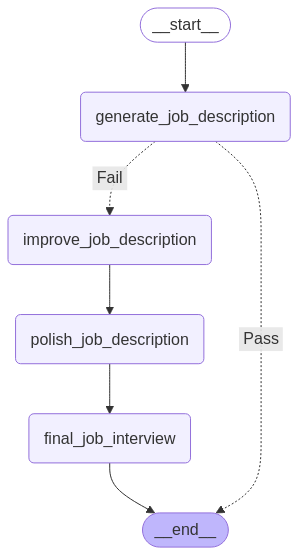

In [164]:
# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

In [165]:
state = chain.invoke({"role": "ML Engineer"})

In [166]:
Markdown(state["final_interview_questions"])

Based on the job description provided, here is a set of interview questions and expected answers for the position of Machine Learning Engineer (Google Cloud Platform Focus):

**Interview Questions:**

1. **Can you describe your educational background and how it prepared you for this role?**
   - *Expected Answer*: The candidate should mention their degree in Computer Science, Mathematics, Statistics, or a related field, and how their coursework or projects have prepared them for the technical challenges of a Machine Learning Engineer.

2. **What experience do you have with machine learning frameworks such as TensorFlow, Keras, and PyTorch? Can you provide an example of a project you've worked on using one of these frameworks?**
   - *Expected Answer*: The candidate should share details about a project where they utilized one of the mentioned frameworks to develop a machine learning model, explaining the problem they were addressing, the architecture of the model, and the results they achieved.

3. **How have you utilized Google Cloud Platform (GCP) in your past projects? Please provide specific examples of GCP services you have used, such as AI Platform or BigQuery.**
   - *Expected Answer*: The candidate should detail their experience with GCP services, providing specific examples of how they have used these services to scale machine learning projects, such as deploying models on AI Platform, or working with large datasets in BigQuery.

4. **Can you explain your approach to designing and implementing data ingestion, processing, and transformation pipelines? How have you used tools like Google Cloud Storage, BigQuery, and Dataflow in these processes?**
   - *Expected Answer*: The candidate should outline their process for setting up and managing data pipelines and should discuss their experience with GCP tools, emphasizing their role in ensuring data quality and efficiency.

5. **How do you stay updated with the latest advancements in machine learning and cloud technologies? Can you provide an example of a recent technology or technique you learned and implemented?**
   - *Expected Answer*: The candidate should discuss their methods for staying current, such as following tech blogs, attending seminars, or participating in online courses. They should also provide a concrete example of a new technology or technique they have adopted in their work.

6. **How do you ensure the performance and scalability of deployed machine learning models? What monitoring and maintenance tools have you used?**
   - *Expected Answer*: The candidate should explain their strategies for monitoring model performance and the specific tools they use, such as Google Cloud Monitoring, to ensure that models are performing optimally and can scale with increasing data or user load.

7. **Can you describe a situation where you had to explain a complex technical concept to non-technical stakeholders? How did you approach this communication?**
   - *Expected Answer*: The candidate should provide an example of a meeting or presentation where they simplified technical information for a non-technical audience. They should discuss their communication style and any visual aids or analogies used.

8. **What experience do you have with MLOps practices and tools? How do you think these can streamline the machine learning lifecycle?**
   - *Expected Answer*: The candidate should discuss their experience with MLOps, including tools they have used, and explain how these practices can make the development, deployment, and maintenance of machine learning models more efficient and scalable.

9. **Given your experience with Google Cloud, how do you think it can be leveraged to solve the business objectives of [Company Name]?**
   - *Expected Answer*: The candidate should demonstrate their understanding of the company’s business challenges and how GCP services can be used to address these, showing a strategic mindset and alignment with the company’s goals.

10. **Can you discuss your experience with Kubernetes and containerization technologies, particularly in the context of deploying machine learning models?**
    - *Expected Answer*: The candidate should provide details about their experience with Kubernetes and containerization, explaining how these technologies are used in deploying machine learning models to ensure scalability, resilience, and efficiency.

These questions aim to assess the candidate's technical skills, problem-solving abilities, and their capacity to integrate machine learning solutions with cloud services, particularly within the GCP ecosystem.

In [167]:
Markdown(state['final_job_description'])

Here is the revised job description with grammatical corrections:

**Job Title: Machine Learning Engineer (Google Cloud Platform Focus)**

**Company Overview:**
[Company Name] is a leading innovator in [industry/field], dedicated to harnessing the power of technology to solve complex challenges. We are currently seeking a highly skilled Machine Learning Engineer to join our dynamic and collaborative team. In this role, you will be working closely with the development team and data scientists to design, develop, and implement machine learning models and solutions, leveraging Google Cloud Platform (GCP) and other Google tools.

**Job Responsibilities:**

- Design, develop, and deploy machine learning models and algorithms that meet specific business objectives and needs.
- Utilize Google Cloud Platform (GCP) services such as Google Cloud AI Platform, TensorFlow, and Cloud Dataflow to build scalable and robust solutions.
- Collaborate with cross-functional teams to identify areas for automation and optimization through the use of machine learning and data analytics.
- Implement and maintain pipelines for data ingestion, processing, and transformation using Google Cloud Storage, BigQuery, and Dataflow.
- Monitor, maintain, and improve the performance of deployed models through continuous evaluation and retraining, utilizing Google Cloud Monitoring and other tools.
- Stay updated with the latest advancements in machine learning and cloud technologies, and apply relevant techniques to improve our products and services.
- Contribute to the development and implementation of best practices for machine learning projects and operations.

**Qualifications:**

- A Bachelor’s or Master’s degree in Computer Science, Mathematics, Statistics, or a related quantitative field.
- Proficiency in Python and experience with machine learning frameworks such as TensorFlow, Keras, and PyTorch.
- Hands-on experience with Google Cloud Platform (GCP), including AI Platform, BigQuery, Dataflow, and other GCP services.
- Strong understanding of data structures, algorithms, and computer science fundamentals.
- Experience with cloud computing and distributed systems, with a focus on GCP.
- Knowledge of data modeling, SQL, and data analysis techniques.
- Excellent problem-solving skills and the ability to work independently as well as in a team setting.
- Strong communication and collaboration skills, with the ability to explain complex technical concepts to non-technical stakeholders.

**Preferred Qualifications:**

- Experience with Google Cloud BigQuery ML for creating and deploying machine learning models directly on BigQuery data.
- Familiarity with Kubernetes and containerization technologies for deploying machine learning models at scale.
- Knowledge of machine learning model deployment and management tools such as Google Cloud AI Platform Model Management.
- Experience with MLOps practices and tools to streamline the machine learning lifecycle.
- A portfolio or project examples that demonstrate the application of machine learning models and GCP services.

**What We Offer:**

- A competitive salary and benefits package.
- Opportunities for professional growth and learning.
- A dynamic and collaborative work environment.
- Access to state-of-the-art tools and technologies, including the full suite of Google Cloud services.
- The chance to work on cutting-edge projects that have a significant impact.

If you are passionate about leveraging machine learning and cloud technologies to drive innovation, we would love to hear from you. Apply today to join a team that values creativity, collaboration, and excellence.

The text has been corrected for grammatical consistency and clarity.

In [158]:
Markdown(state['improved_job_description'])

Job Title: Google Cloud Platform (GCP) Data Analyst

Job Summary:
We are seeking a talented and detail-oriented Google Cloud Platform (GCP) Data Analyst to join our dynamic team. The ideal candidate will have a deep understanding of Google's suite of tools and services, particularly within the GCP ecosystem. The role involves leveraging GCP and other Google tools to extract meaningful insights from large datasets, enabling data-driven decision-making within the organization.

Responsibilities:
- Utilize Google Cloud Platform (GCP) services, including BigQuery, Dataflow, and Cloud Storage, to manage and analyze large datasets.
- Develop and maintain data models, utilizing Google’s BigQuery for advanced analytics and to support business intelligence needs.
- Create and update dashboards and reports using Google Data Studio to visualize data and insights.
- Collaborate with cross-functional teams to understand data requirements and provide actionable insights.
- Implement data pipelines using Google Cloud Dataflow to automate data processing and integration.
- Work with Google Sheets and Google Workspace to streamline data management and collaboration processes.
- Contribute to the design and development of machine learning models using TensorFlow and other GCP AI/ML services.
- Evaluate and optimize data processing workflows to ensure efficiency and scalability within GCP.
- Provide training and support to team members on the effective use of Google’s data analysis tools and platforms.

Requirements:
- Bachelor’s degree in Computer Science, Mathematics, Statistics, or a related field; a Master’s degree is a plus.
- Proven experience as a Data Analyst with a strong background in Google Cloud Platform (GCP).
- Proficiency in using BigQuery, Dataflow, and other GCP data management and analytics tools.
- Experience with Google Data Studio for data visualization and dashboard creation.
- Excellent knowledge of SQL for querying large datasets within GCP.
- Experience with Python or another programming language for data manipulation and analysis.
- Familiarity with TensorFlow and GCP’s AI/ML services for machine learning applications.
- Strong analytical and problem-solving skills with a keen eye for detail.
- Ability to effectively communicate complex data insights to both technical and non-technical stakeholders.
- Excellent collaboration and teamwork skills to work closely with developers, data engineers, and other stakeholders.

This role is a fantastic opportunity for someone passionate about leveraging Google’s powerful tools to drive data-driven insights and decision-making. If you have a passion for data, technology, and a desire to solve complex problems, we encourage you to apply.